# Recheck last part of part 2

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import acos, sqrt, pi, cos

def cvtGrayscale(img):
    if len(img.shape) < 3:
        return img
    b, l, c = img.shape
    gray = np.zeros((b,l), dtype = "int64")
    for i in range(b):
        for j in range(l):
            gray[i][j] = (0.299*img[i][j][0] + 0.587*img[i][j][1] + 0.114*img[i][j][2])
    return gray

## 1) Find the cell organs of interest in the image cell.png. Use the same code to show your outputs on flower.jpeg.

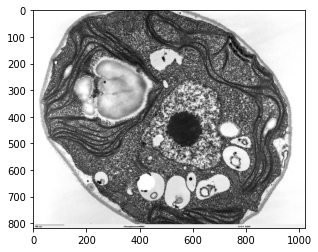

In [2]:
img_cell = cv2.imread("../images/cell.png")
plt.imshow(img_cell, cmap="gray")

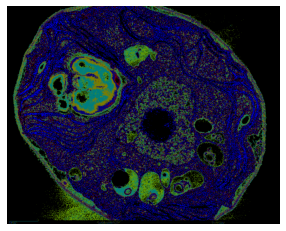

In [3]:
levels = [[255,0,0],[255,0,0],[0,0,255],[0,0,255],[0,0,0],[0,0,0],[125,0,0],[0,0,125],[0,0,125],[125,125,0],[125,125,0],[0,125,125],[0,125,125],[100,155,0],[100,155,0],[0,255,0]]
def psuedocolor(img, levels):
    if len(img.shape) > 2:
        img = cvtGrayscale(img)
    b, l = img.shape
    out = np.zeros((b,l,3), dtype='int64')
    #lets take 16 colors 
    #print(levels[9])
    for i in range(b):
        for j in range(l):
            out[i][j] = levels[(img[i][j])//17]
            if img[i][j] > 230:
                out[i][j] = 0
            elif img[i][j] < 50:
                out[i][j] = 0
    return out
plt.axis("off")
plt.imshow(psuedocolor(img_cell, levels))

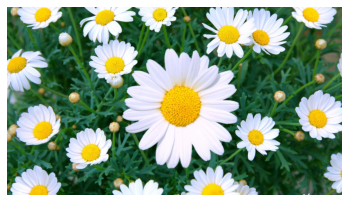

In [4]:
img_flower = cv2.imread('../images/flower.jpeg')
img_flower = cv2.cvtColor(img_flower, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img_flower)

16


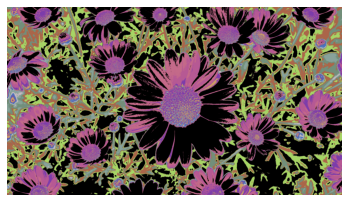

In [5]:
levels = np.random.randint(50,220,size=(16,3),dtype='int64')
plt.axis('off')
print(len(levels))
plt.imshow(psuedocolor(img_flower, levels))

## 2) Read in the binary image objects.png and write a script which uses the image as input and answers the following questions.

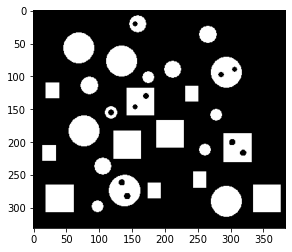

In [6]:
img_obj = cv2.imread("../images/objects.png")
plt.imshow(img_obj)

186


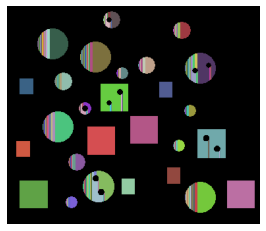

In [7]:
def onePass(img):
    out = np.copy(img)
    if len(img.shape) > 2:
        img = cvtGrayscale(img)
    else:
        out = np.zeros((img.shape[0],img.shape[1],3))
    b, l = img.shape
    segments = np.copy(img)
    s = 0
    for i in range(b):
        for j in range(l):
            if img[i][j] == 0:
                segments[i][j] = 0
            else:
                if i>0:
                    if segments[i-1][j] != 0:
                        segments[i][j] = segments[i-1][j]
                    elif j>0 and segments[i][j-1] != 0:
                        segments[i][j] = segments[i][j-1]
                    else:
                        segments[i][j] = s+1
                        s+=1
                else:
                    if j>0 and segments[i][j-1] != 0:
                        segments[i][j] = segments[i][j-1]
                    else:
                        segments[i][j] = s+1
                        s+=1
    colors = np.random.randint(50,220,size=(s,3),dtype='int64')
    for i in range(b):
        for j in range(l):
            if img[i][j] == 255:
                out[i][j] = colors[segments[i][j]-1]
    return out, s
plt.axis('off')
out, s = onePass(img_obj)
print(s)
plt.imshow(out)

28


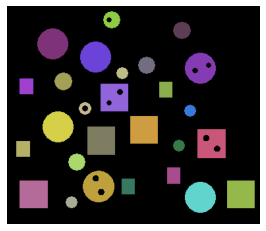

In [8]:
def twoPass(img):
    out = np.copy(img)
    if len(img.shape) > 2:
        img = cvtGrayscale(img)
    else:
        out = np.zeros((img.shape[0],img.shape[1],3))
    b, l = img.shape
    segments = np.zeros(img.shape, dtype='int64')
    unionfind = []
    s = 0
    unionfind.append(s)

    for i in range(b):
        for j in range(l):
            if img[i][j] == 255:
                if i>0 and j>0:
                    if segments[i-1][j] > 0 and segments[i][j-1] > 0:
                        top = unionfind[segments[i-1][j]]
                        left = unionfind[segments[i][j-1]]
                        unionfind[int(max(left,top))] = min(top, left)
                        segments[i][j] = min(top,left)
                    elif segments[i-1][j] > 0:
                        segments[i][j] = segments[i-1][j]
                    elif segments[i][j-1] > 0:
                        segments[i][j] = segments[i][j-1]
                    else:
                        s+=1
                        segments[i][j] = s
                        unionfind.append(s)
                elif i>0:
                    if segments[i-1][j]>0:
                        segments[i][j] = segments[i-1][j]
                elif j>0:
                    if segments[i][j-1]>0:
                        segments[i][j] = segments[i][j-1]
                else:
                    s+=1
                    segments[i][j] = s
                    unionfind.append(s)

    #print(s)
    for i in range(b):
        for j in range(l):
            if segments[i][j] > 0:
                curr = unionfind[segments[i][j]]
                while unionfind[int(curr)] != int(curr):
                    curr = unionfind[curr]
                unionfind[segments[i][j]] = curr
                segments[i][j] = curr
                
    #print(unionfind, s)
    colors = np.random.randint(50,220,size=(s,3),dtype='int64')
    for i in range(b):
        for j in range(l):
            if img[i][j] == 255:
                out[i][j] = colors[segments[i][j]-1]
    return out, segments, len(np.unique(unionfind))
plt.axis('off')
out1, segments, s1 = twoPass(img_obj)
print(s1)
plt.imshow(out1)

In [9]:
def findshape(segments):
    b, l = segments.shape
    clusters = np.unique(segments[np.where(segments != 0)])

    extremes = []
    for c in clusters:
        maxx = -1
        maxy = -1
        minx = b+1
        miny = l+1
        for i in range(b):
            for j in range(l):
                if segments[i][j] == c:
                    if i < minx:
                        minx = i
                    elif i > maxx:
                        maxx = i
                    if j < miny:
                        miny = j
                    elif j > maxy:
                        maxy = j
        extremes.append([minx,maxx,miny,maxy])     #[minx, maxx, miny, maxy]
    extremes = np.array(extremes)
    
    clustershape = []
    for c in clusters:
        minx,maxx,miny,maxy = extremes[np.where(clusters == c)][0]
        found = False
        for i in range(b):
            for j in range(l):
                if segments[i][j] == c:
                    if (i == minx and j == miny) or (i == minx and j == maxy) or (i == maxx and j == maxy) or (i == maxx and j == miny):
                        clustershape.append(1)
                        found = True
                        break
            if found:
                break
        if not found:
            clustershape.append(0)
    
    clusterhole = []
    for c in clusters:
        minx,maxx,miny,maxy = extremes[np.where(clusters == c)][0]
        hole = False
        for i in range(minx,maxx+1):
            flag1 = False
            flag2 = False
            flag3 = False
            for j in range(miny, maxy + 1):
                if not flag1 and segments[i][j] == c:
                    flag1 = True
                if flag1 and (not flag2) and segments[i][j] == 0:
                    flag2 = True
                if flag1 and flag2 and segments[i][j] == c:
                    flag3 = True
            if flag1 and flag2 and flag3:
                hole = True
                break
        if hole:
            clusterhole.append(1)
        else:
            clusterhole.append(0)
                
    print(len(clustershape), len(clusterhole))
    return clustershape, clusterhole

clustershape, clusterhole = findshape(segments)
clustershape = np.array(clustershape)
clusterhole = np.array(clusterhole)
print("Number of shapes with one or more holes = ", len(clusterhole[np.where(clusterhole == 1)]))
print("Number of squares in the image(including the ones with holes) = ",len(clustershape[np.where(clustershape == 1)]))
arr1 = clusterhole*clustershape
print("Number of squares with holes = ", len(arr1[np.where(arr1 == 1)]))
arr2 = clusterhole + clustershape
print("Number of circles with no holes = ", len(arr2[np.where(arr2 == 0)]))

27 27
Number of shapes with one or more holes =  6
Number of squares in the image(including the ones with holes) =  11
Number of squares with holes =  2
Number of circles with no holes =  12


### 3) Read in the binary image circles.jpg and write a script which uses the image as input and outputs a new image containing

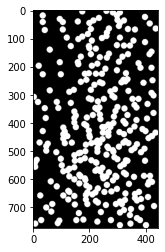

In [10]:
img_circles = cv2.imread('../images/circles.jpg')
plt.imshow(img_circles)

### (a) only the coins touching the boundary of the image

5133


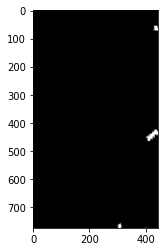

In [11]:
out1, segments, s1 = twoPass(img_circles)
print(s1)
preserve = []
b,l = segments.shape
for i in range(b):
    for j in range(l):
        if segments[i][j] > 0:
            if i==0 or i== b-1 or j==0 or j==l-1:
                if segments[i][j] not in preserve:
                    preserve.append(segments[i][j])

out = np.copy(segments) 
for i in range(b):
    for j in range(l):
        if segments[i][j] in preserve:
            out[i][j] = 255
        else:
            out[i][j] = 0
plt.imshow(out, cmap='gray')

### (b) only the coins which overlap with each other

In [14]:
preserve = []
def findCircles(segments, s):
    b, l = segments.shape
    clusters = np.unique(segments[np.where(segments != 0)])

    extremes = []
    for c in clusters:
        maxx = -1
        maxy = -1
        minx = b+1
        miny = l+1
        for i in range(b):
            for j in range(l):
                if segments[i][j] == c:
                    if i < minx:
                        minx = i
                    elif i > maxx:
                        maxx = i
                    if j < miny:
                        miny = j
                    elif j > maxy:
                        maxy = j
        extremes.append([minx,maxx,miny,maxy])     #[minx, maxx, miny, maxy]
    extremes = np.array(extremes)
    
    isCircle = []
    
    for c in clusters:
        minx,maxx,miny,maxy = extremes[np.where(clusters == c)][0]
        if (maxx-minx) == (maxy-miny):
            isCircle.append(1)
        else:
            isCircle.append(0)
            preserve.append(c)
    return isCircle

circles = findCircles(segments, s1)
circles = np.array(circles)
print("No. of overlapping circles = ", len(circles[np.where(circles == 0)]))
print("No. of non-overlapping circles = ", len(circles[np.where(circles == 1)]))

No. of overlapping circles =  4457
No. of non-overlapping circles =  675


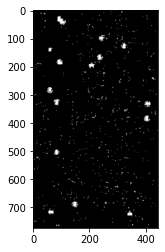

In [13]:
out = np.copy(segments) 
for i in range(b):
    for j in range(l):
        if segments[i][j] in preserve:
            out[i][j] = 255
        else:
            out[i][j] = 0
plt.imshow(out, cmap='gray')

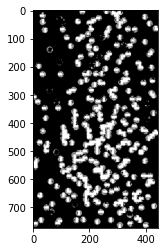

In [15]:
out = np.copy(segments) 
for i in range(b):
    for j in range(l):
        if segments[i][j] in preserve:
            out[i][j] = 255
        else:
            out[i][j] = 0
plt.imshow(out, cmap='gray')